In [1]:
# Set the working directory to the parent directory
import sys
sys.path.append('..')
sys.dont_write_bytecode = True

# Import relevant custom libraries
from src.eda import data_info
from src.models import AutoencoderTrainer, AnomalyDetector
from src.evaluation import ValidationEvaluation

# Import relevant libraries
import pandas as pd
import warnings
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from datetime import datetime
import re
import tensorflow as tf
import pickle
from datetime import datetime
import math

# Config
pd.set_option('display.max_columns', None) # Ensure all columns are displayed
warnings.filterwarnings("ignore")

In [2]:
# Read relevant files
X_train = pd.read_feather("../data/processed/X_train.feather")
X_train_validate = pd.read_feather("../data/processed/X_train_validate.feather")

# Get data info
var_info = data_info(X_train)
all_cols = X_train.columns
real_cols = var_info[var_info["var_type"]=="numerical"]["var_name"].tolist()
binary_cols = var_info[var_info["var_type"]=="binary"]["var_name"].tolist()

## 1. Test the trainer

In [3]:
"""ae = AutoencoderTrainer(
    input_dim=X_train.shape[1],
    real_cols=real_cols,
    binary_cols=binary_cols,
    all_cols=all_cols,
    hidden_dims=[64],
    learning_rate=0.0001,
    dropout_rate=0.2,
    lam=0.0001,
    gamma=0.25,
    verbose=True,
    max_epochs=500,
    plot_losses=True,
    dp_sgd=True,
    target_epsilon=3,
    delta=1e-5,
    batch_size=256,
    l2norm_pct=90,
    patience_limit=20,
    c2=1.5
)
autoencoder = ae.train(X_train, X_train_validate)"""

'ae = AutoencoderTrainer(\n    input_dim=X_train.shape[1],\n    real_cols=real_cols,\n    binary_cols=binary_cols,\n    all_cols=all_cols,\n    hidden_dims=[64],\n    learning_rate=0.0001,\n    dropout_rate=0.2,\n    lam=0.0001,\n    gamma=0.25,\n    verbose=True,\n    max_epochs=500,\n    plot_losses=True,\n    dp_sgd=True,\n    target_epsilon=3,\n    delta=1e-5,\n    batch_size=256,\n    l2norm_pct=90,\n    patience_limit=20,\n    c2=1.5\n)\nautoencoder = ae.train(X_train, X_train_validate)'

## 2. Test the anomaly detector

In [4]:
"""# Read relevant files
X_validate = pd.read_feather("../data/processed/X_validate.feather")
y_validate = pd.read_feather("../data/processed/y_validate.feather")

# After training
detector = AnomalyDetector(
    model=autoencoder,
    real_cols=real_cols,
    binary_cols=binary_cols,
    all_cols=all_cols,
    lam=ae.lam,
)

# Compute scores
scores = detector._compute_anomaly_scores(X_validate)

# Detect
threshold = np.quantile(scores, 0.8)
y_pred = detector._detect(scores, threshold)

# Evaluate
metrics = detector._evaluate(y_pred, y_validate, scores)
print(metrics)"""

'# Read relevant files\nX_validate = pd.read_feather("../data/processed/X_validate.feather")\ny_validate = pd.read_feather("../data/processed/y_validate.feather")\n\n# After training\ndetector = AnomalyDetector(\n    model=autoencoder,\n    real_cols=real_cols,\n    binary_cols=binary_cols,\n    all_cols=all_cols,\n    lam=ae.lam,\n)\n\n# Compute scores\nscores = detector._compute_anomaly_scores(X_validate)\n\n# Detect\nthreshold = np.quantile(scores, 0.8)\ny_pred = detector._detect(scores, threshold)\n\n# Evaluate\nmetrics = detector._evaluate(y_pred, y_validate, scores)\nprint(metrics)'

## 3. Hyperparameter Tuning

### 3.1. Tuning Implementation

In [5]:
# Epsilon = 1
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric auc --n_calls=40 --epsilon 1 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric precision --n_calls=40 --epsilon 1 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric f1_score --n_calls=40 --epsilon 1 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric recall --n_calls=50 --epsilon 1 --delta 1e-5
# Epsilon = 3
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric auc --n_calls=30 --epsilon 3 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric precision --n_calls=40 --epsilon 3 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric f1_score --n_calls=40 --epsilon 3 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric recall --n_calls=50 --epsilon 3 --delta 1e-5
# Epsilon = 5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric auc --n_calls=30 --epsilon 5 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric precision --n_calls=30 --epsilon 5 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric f1_score --n_calls=30 --epsilon 5 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric recall --n_calls=30 --epsilon 5 --delta 1e-5

### 3.2. Summarize the Performance on Validation Set

In [6]:
# Read relevant files
X_validate = pd.read_feather("../data/processed/X_validate.feather")
y_validate = pd.read_feather("../data/processed/y_validate.feather")

# Initialize the validation evaluation
valeval = ValidationEvaluation(X_validate, y_validate, real_cols, binary_cols, all_cols, dp_sgd=True)
    
# Read the log file
log_path = "../logs/dpsgd_tune_log.txt"

# Extract the latest successful Bayesian versions
latest_successful_versions = valeval.extract_latest_successful_bayesian_versions(log_path)
print(latest_successful_versions)

# Evaluate the model performance
eval_results = valeval.evaluate_model_performance(latest_successful_versions)
display(eval_results[eval_results["epsilon"]>=1])

{'202504191621': ('AUC', 1.0, 1e-05), '202504191913': ('Precision', 1.0, 1e-05), '202504192100': ('F1-Score', 1.0, 1e-05), '202504192230': ('Recall', 1.0, 1e-05), '202504200033': ('AUC', 3.0, 1e-05), '202504200040': ('F1-Score', 3.0, 1e-05), '202504200102': ('Precision', 3.0, 1e-05), '202504200118': ('Recall', 3.0, 1e-05), '202504201003': ('AUC', 5.0, 1e-05), '202504201008': ('F1-Score', 5.0, 1e-05), '202504201043': ('Precision', 5.0, 1e-05), '202504201058': ('Recall', 5.0, 1e-05), '202504201115': ('AUC', 0.5, 1e-05), '202504201317': ('F1-Score', 0.5, 1e-05)}
Evaluating version 202504191621
Evaluating version 202504191913
Evaluating version 202504192100
Evaluating version 202504192230
Evaluating version 202504200033
Evaluating version 202504200040
Evaluating version 202504200102
Evaluating version 202504200118
Evaluating version 202504201003
Evaluating version 202504201008
Evaluating version 202504201043
Evaluating version 202504201058
Evaluating version 202504201115
Evaluating version

,precision,recall,f1_score,auc,accuracy,hidden_dims,batch_size,dropout_rate,learning_rate,lam,gamma,l2norm_pct,threshold,tuned_by,epsilon,delta
version,,,,,,,,,,,,,,,,
202504191913,0.577661,0.143601,0.230021,0.631403,0.806581,"[64, 32]",64.0,0.000000,0.000050,0.000100,0.001000,95.0,28.740422,Precision,1.0,0.00001
202504200102,0.760908,0.189154,0.302988,0.657486,0.824911,"[64, 32]",64.0,0.000000,0.000260,0.000100,0.696594,95.0,8.775871,Precision,3.0,0.00001
202504201043,0.746946,0.185683,0.297429,0.655450,0.823514,"(64, 32)",64.0,0.141950,0.001100,0.000100,0.730920,95.0,7.494475,Precision,5.0,0.00001
202504192230,0.412569,0.615184,0.493905,0.746566,0.746356,"(64, 32)",64.0,0.226863,0.000050,0.000100,0.940053,76.0,2.468308,Recall,1.0,0.00001
202504200118,0.418388,0.623861,0.500871,0.761876,0.749847,"[64, 32]",71.0,0.400000,0.000310,0.000100,0.999000,79.0,0.310694,Recall,3.0,0.00001
202504201058,0.420134,0.626464,0.502961,0.756796,0.750895,"(64, 32)",64.0,0.400000,0.001100,0.030479,0.999000,95.0,1.756952,Recall,5.0,0.00001
202504192100,0.462698,0.546204,0.500995,0.747320,0.781095,"[64, 32]",69.0,0.000000,0.000050,0.049086,0.999000,75.0,5.829693,F1-Score,1.0,0.00001
202504200040,0.472620,0.557918,0.511739,0.757241,0.785808,"(64, 32)",64.0,0.400000,0.000489,0.000100,0.999000,84.0,0.369922,F1-Score,3.0,0.00001
202504201008,0.474825,0.560521,0.514127,0.753921,0.786855,"[64, 32]",76.0,0.400000,0.001100,0.001101,0.999000,82.0,0.553038,F1-Score,5.0,0.00001


In [7]:
eval_results.to_csv("../experiments/perf_summary/dpsgd_val_results.csv")

### 3.3. Inspect Convergence of Bayesian Optimization

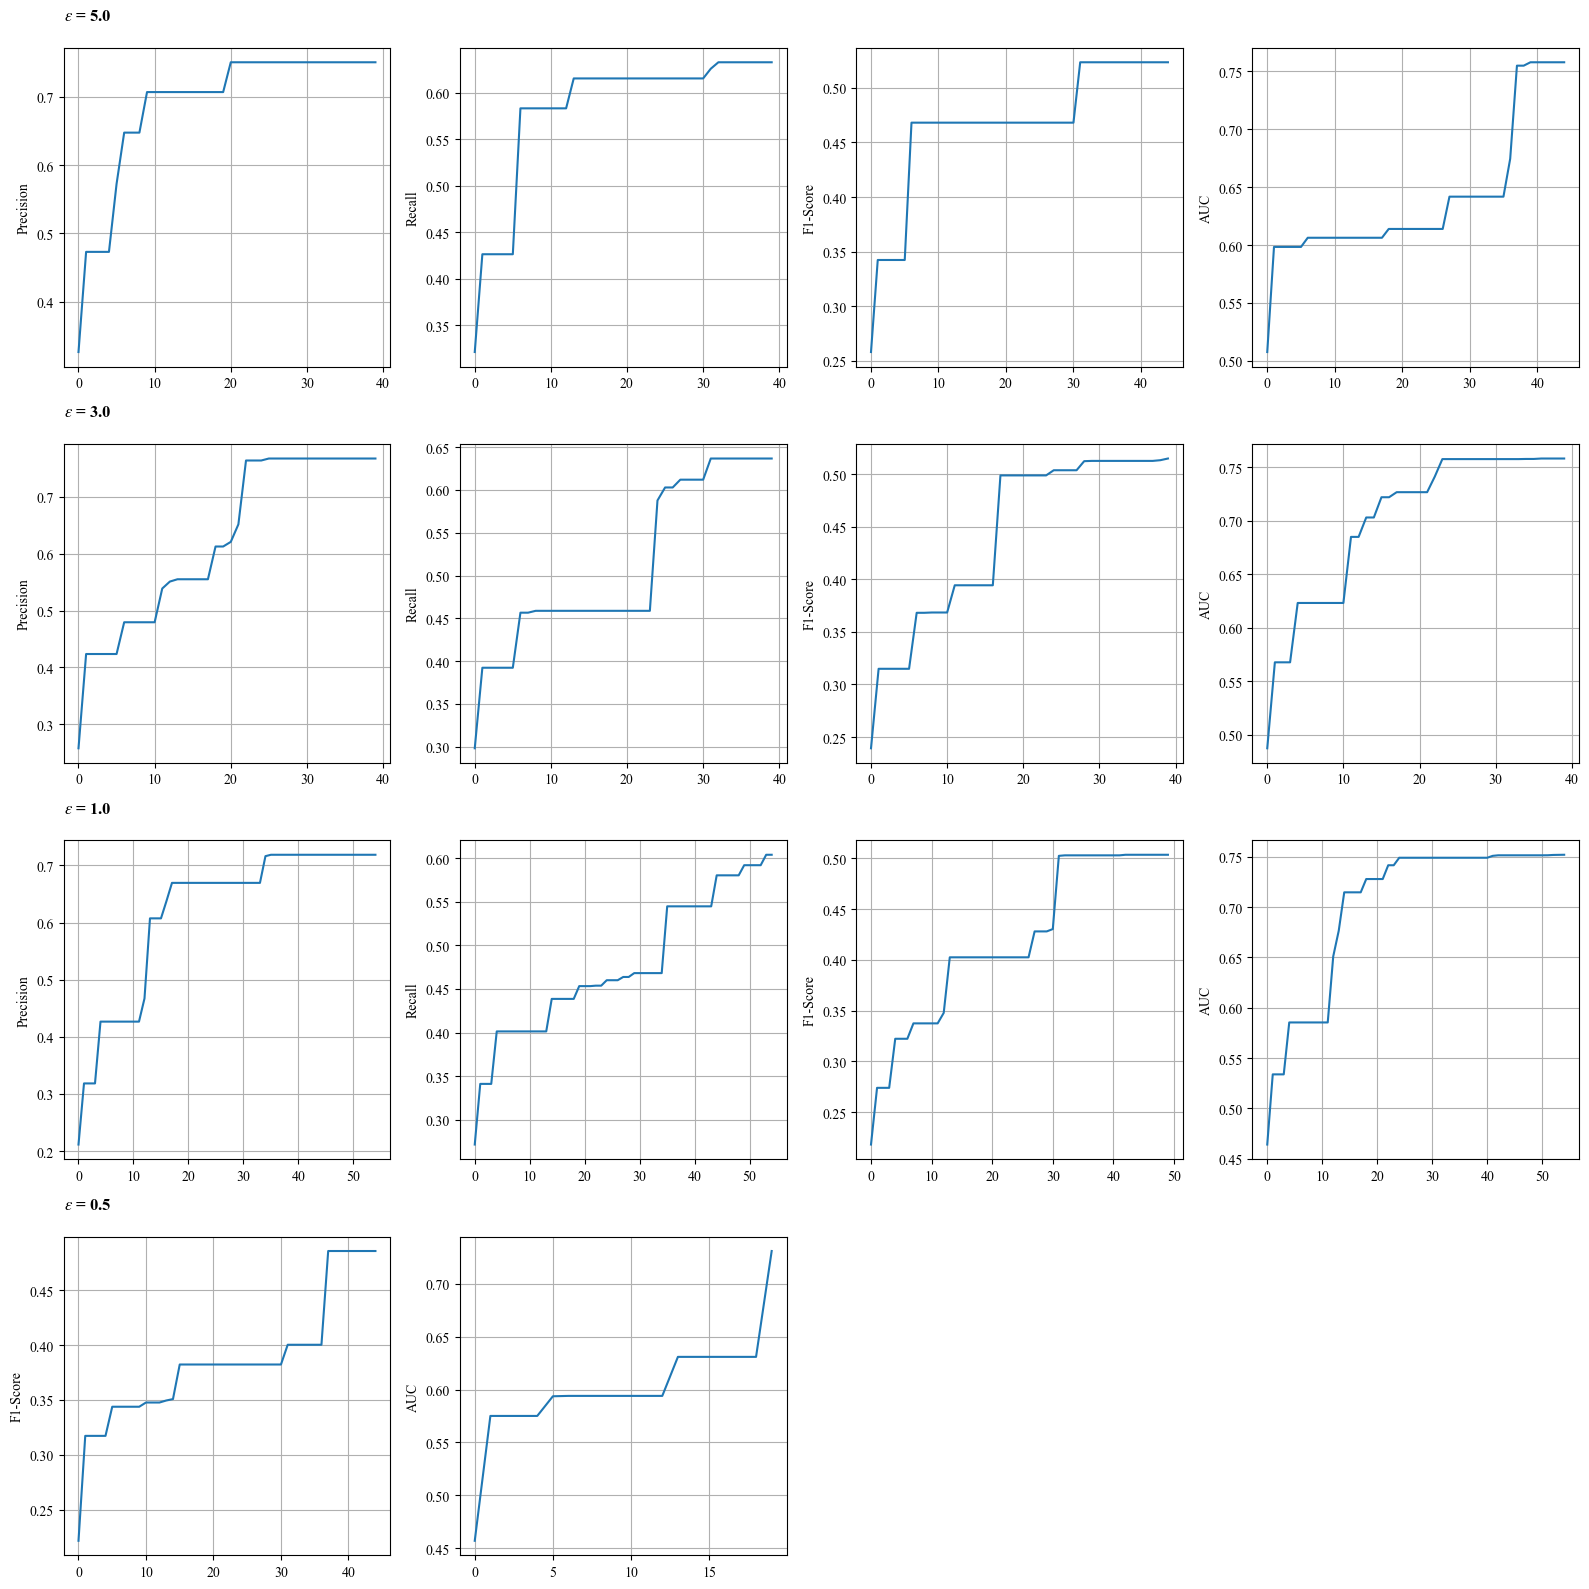

In [8]:
# Sort and reset index for consistent iteration
sorted_results = eval_results.sort_values(by=["epsilon"], ascending=False).reset_index()

# Set up grid
n_cols = 4
n_rows = math.ceil(len(sorted_results) / n_cols)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

# Track previous epsilon for row titles
row_epsilons = []

for i, row in sorted_results.iterrows():
    ax = axes[i]
    metric = row["tuned_by"].lower().replace("-", "_")
    version = row["version"]
    epsilon = row["epsilon"]

    # Read result file
    results_df = pd.read_csv(f"../experiments/hyperparam_tune/dpsgd/bayes_{metric}_{version}.csv")
    results_df["best_so_far"] = results_df[metric].cummax()

    # Plot
    ax.plot(results_df.index, results_df["best_so_far"])
    ax.set_ylabel(row["tuned_by"])
    ax.grid(True)

    # If it's the first column in a row, set a title for that row
    if i % n_cols == 0:
        ax.set_title(f"$\\varepsilon$ = {epsilon}", loc='left', fontsize=12, fontweight='bold', pad=20)

# Hide unused subplots if total is not a multiple of n_cols
for j in range(len(sorted_results), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 3.4. Compare Models Based on Validation Set

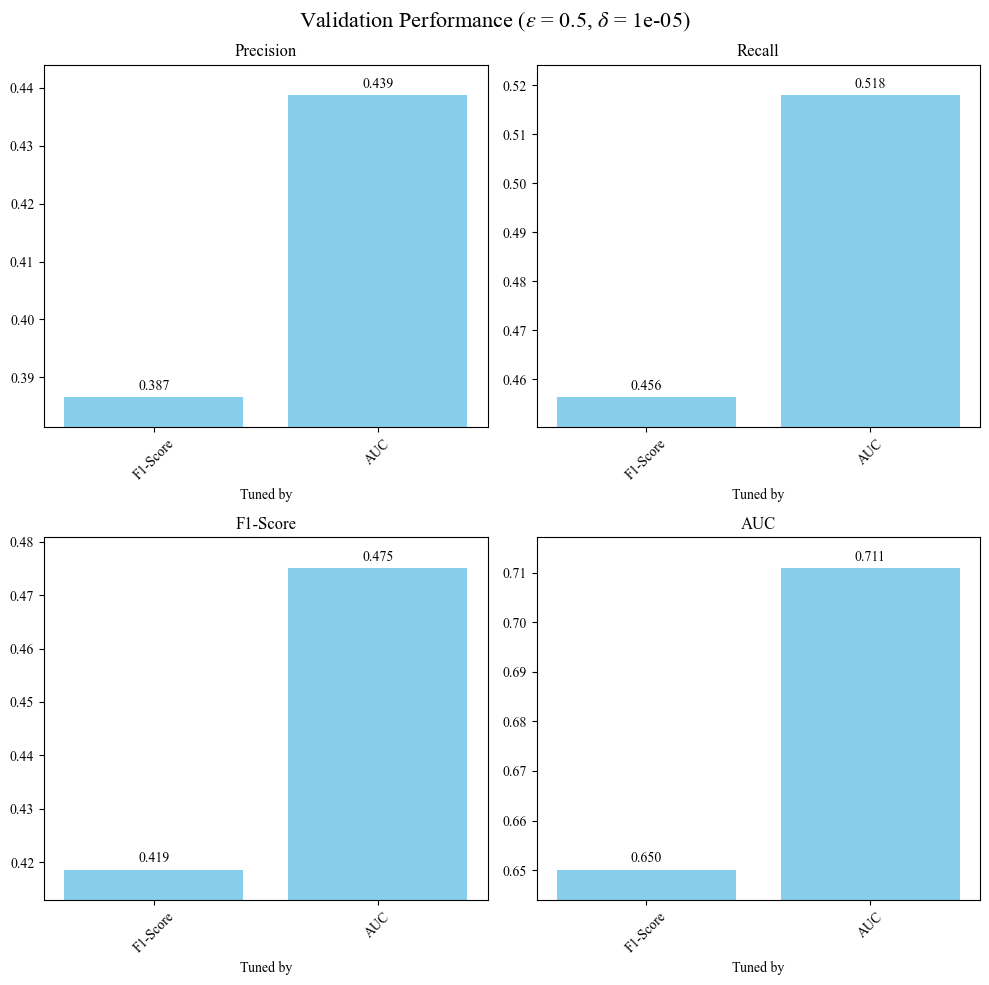

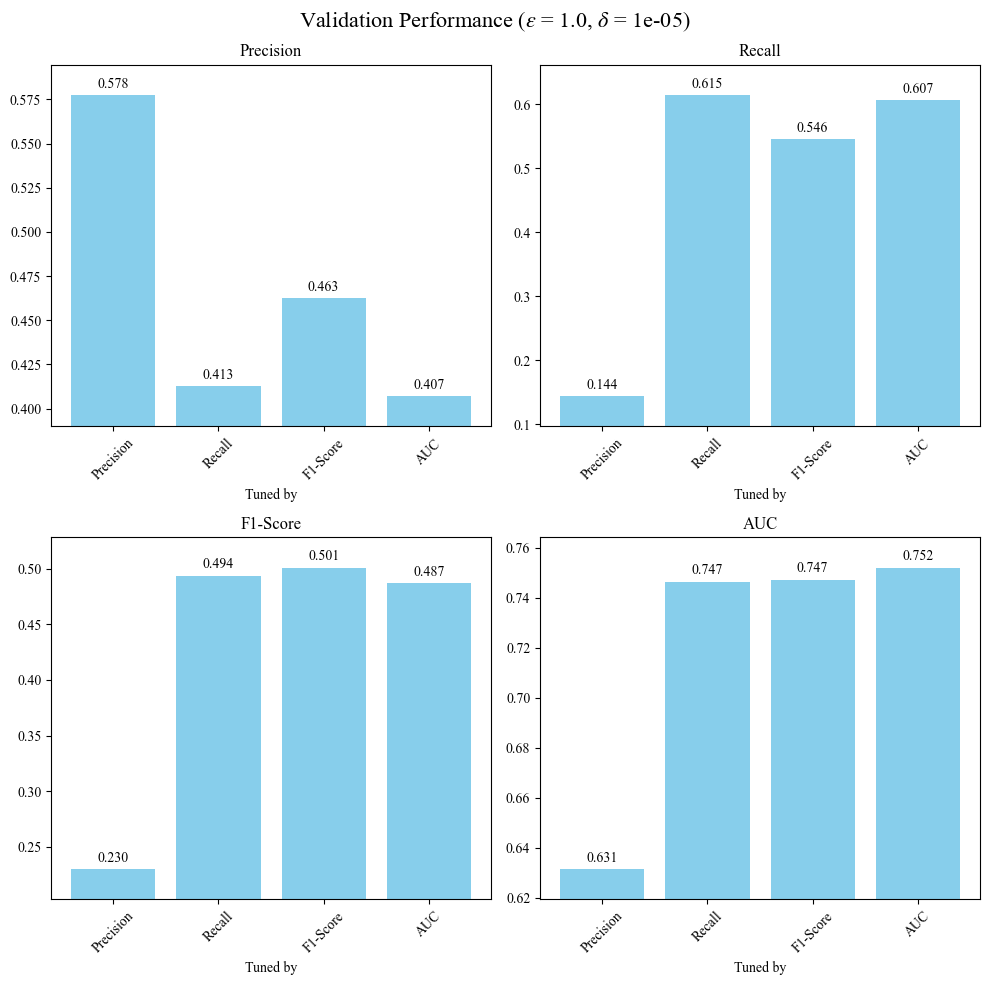

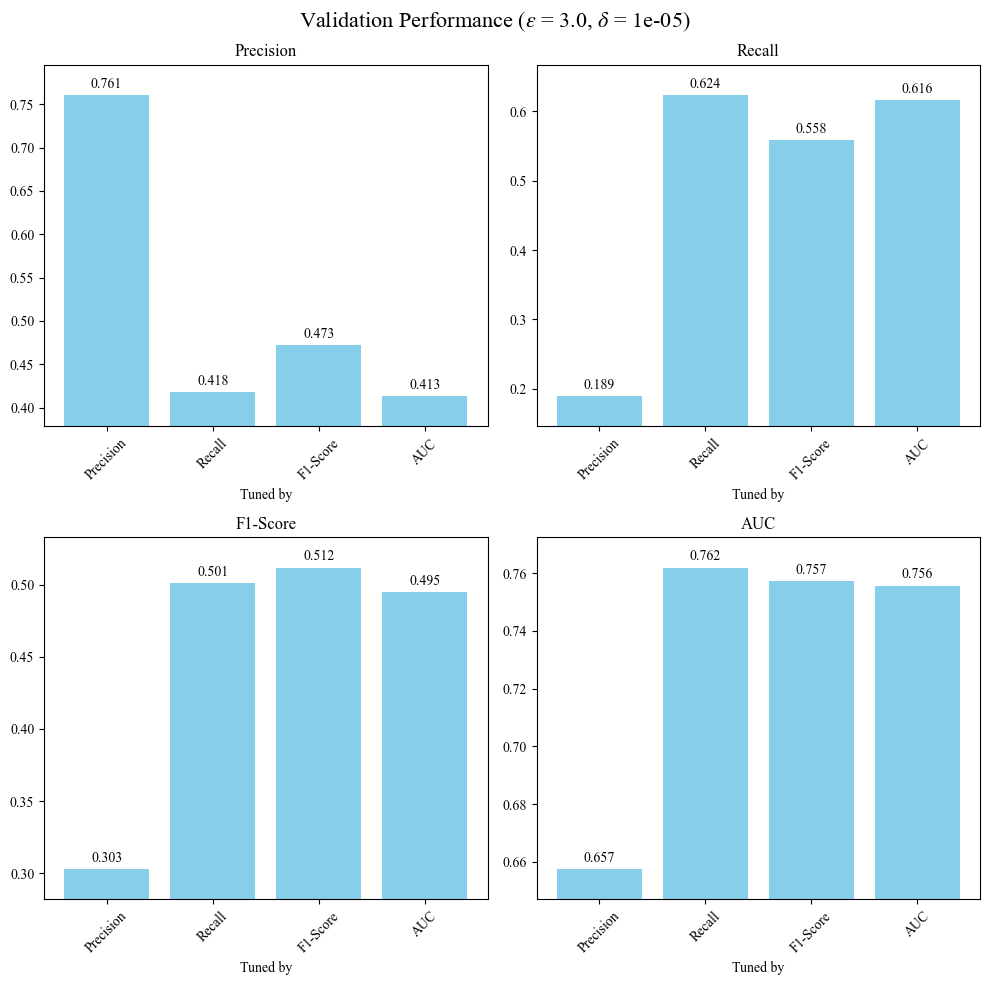

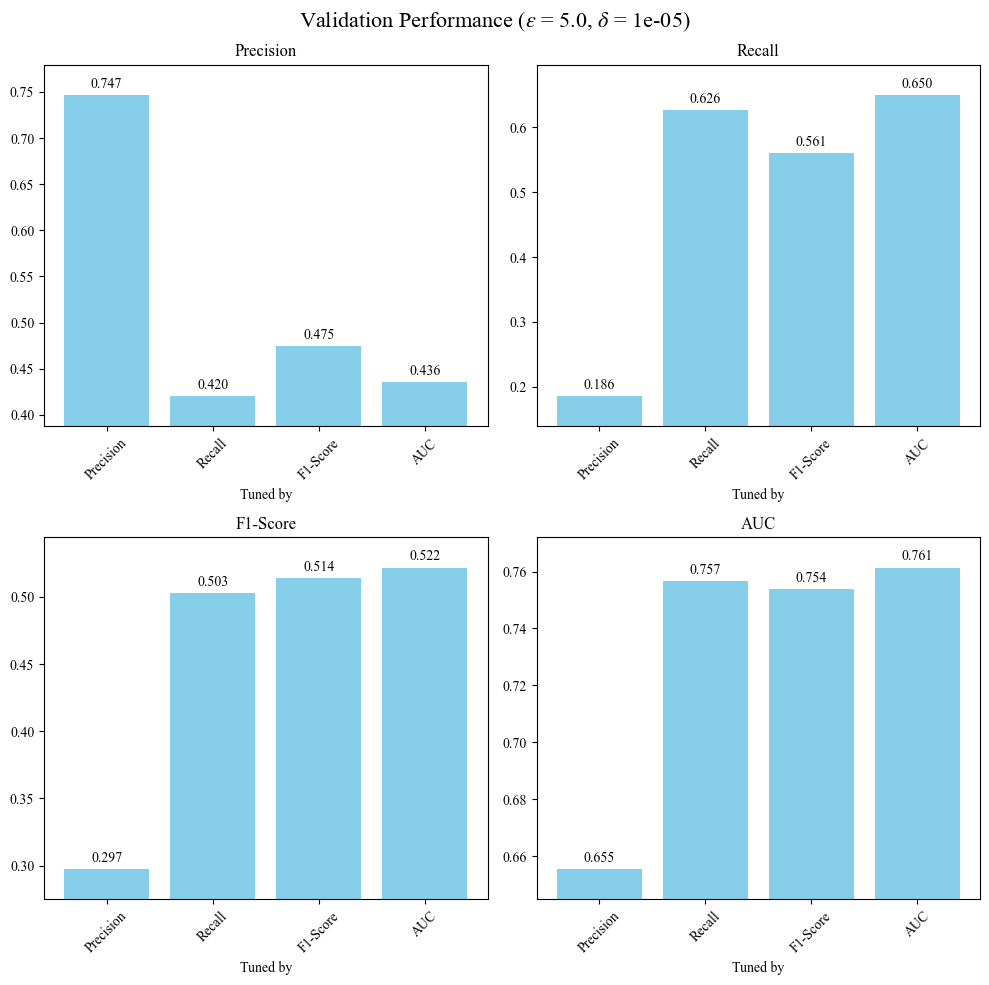

In [9]:
##################################################
## Plot a barplot of the validation performance ##
##################################################

valeval.plot_bar(eval_results, save=False)

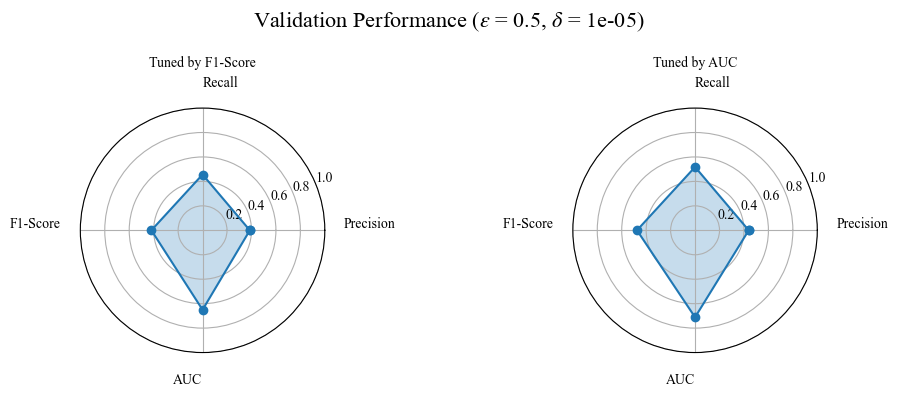

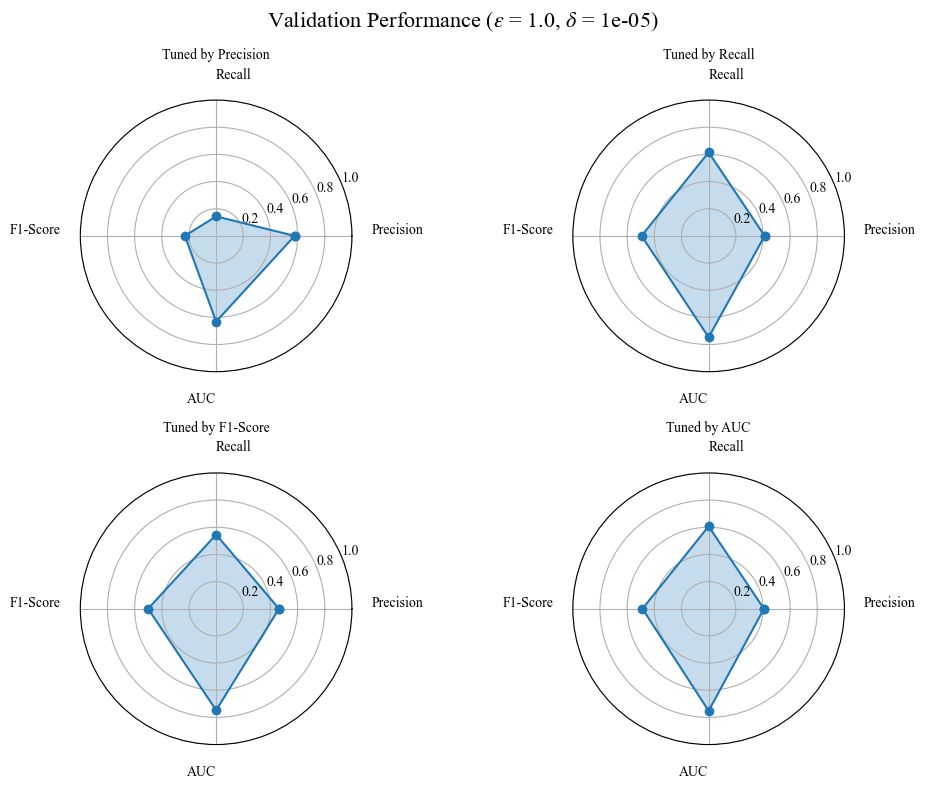

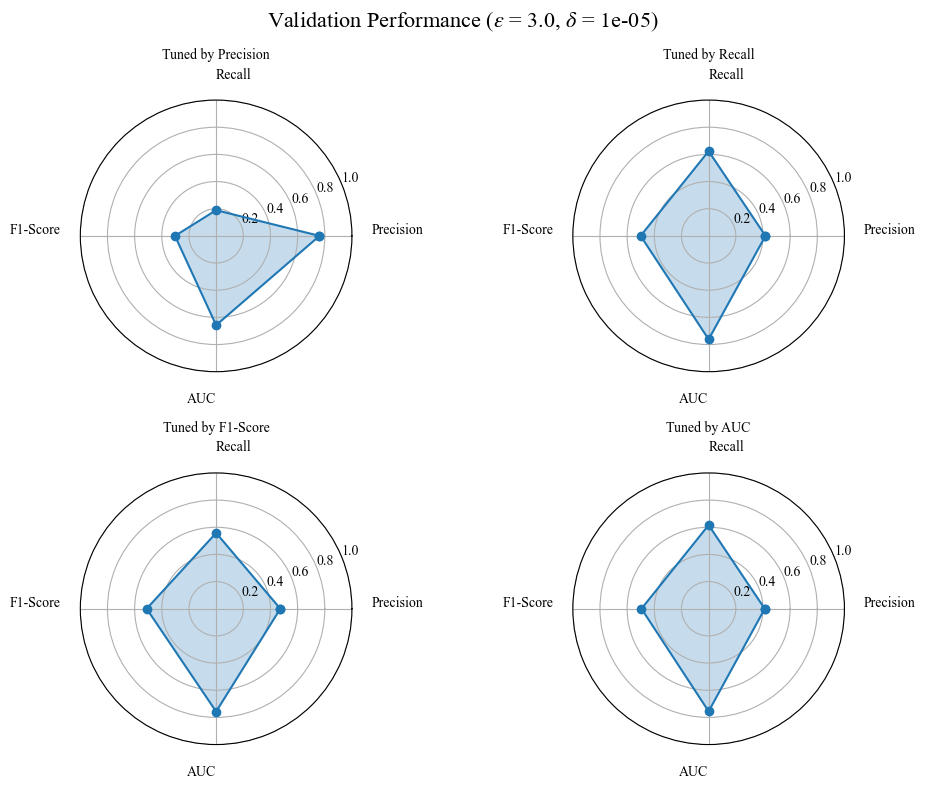

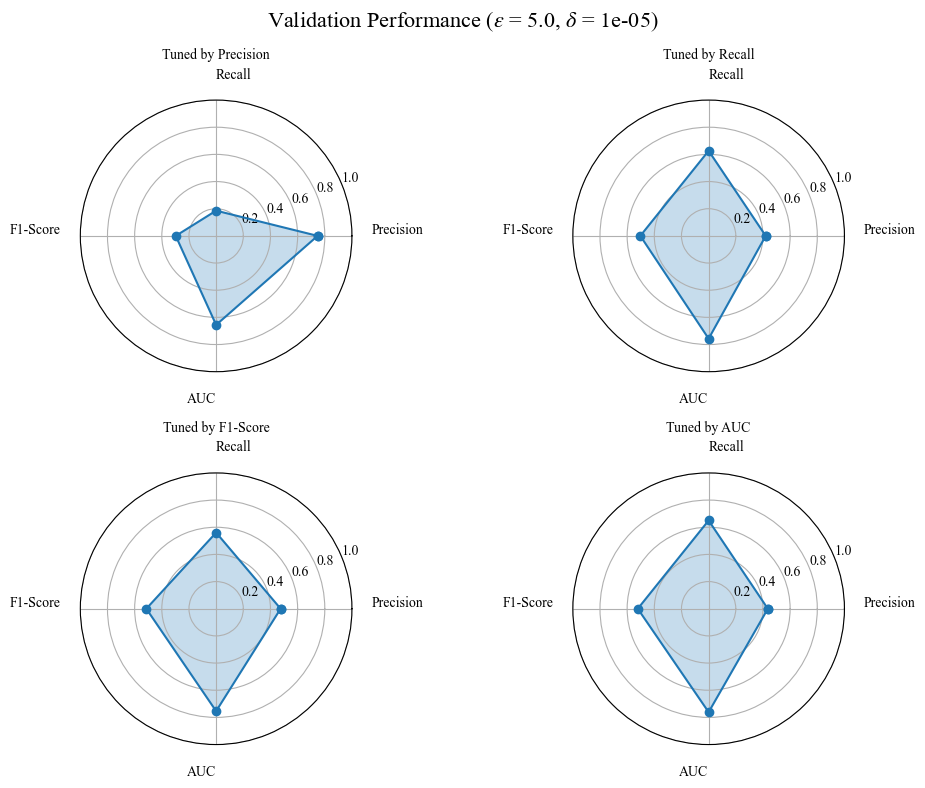

In [10]:
#####################################################
## Plot a radar plot of the validation performance ##
#####################################################
 
valeval.plot_radar(eval_results)

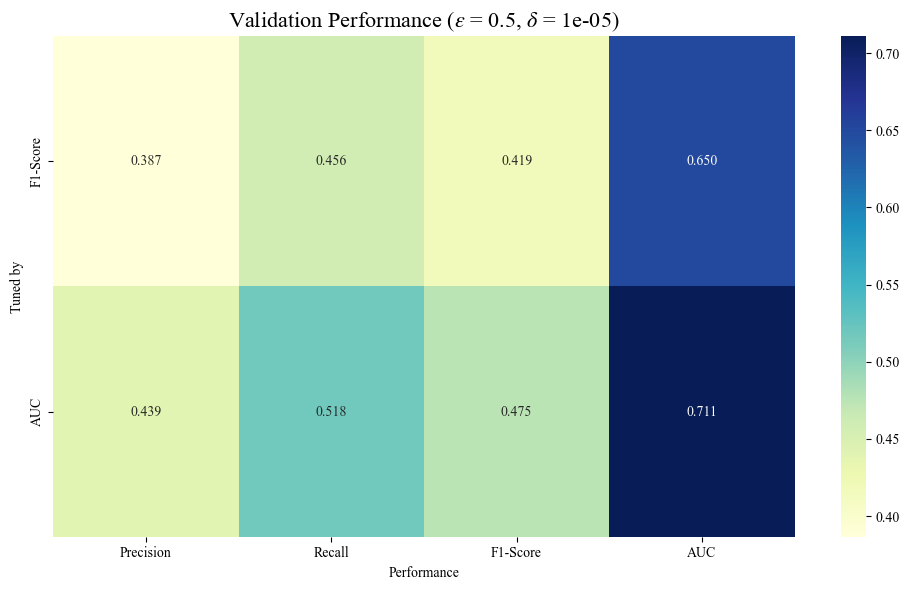

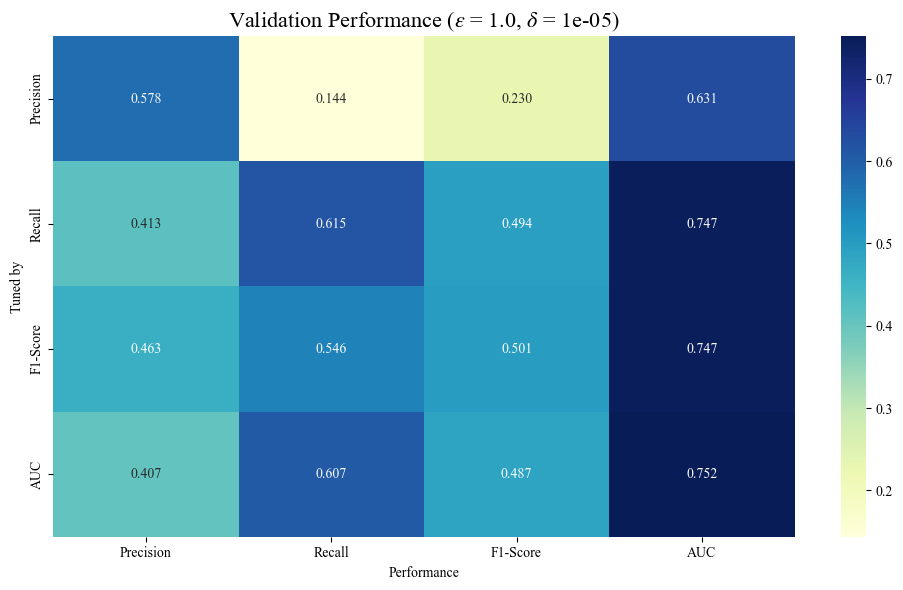

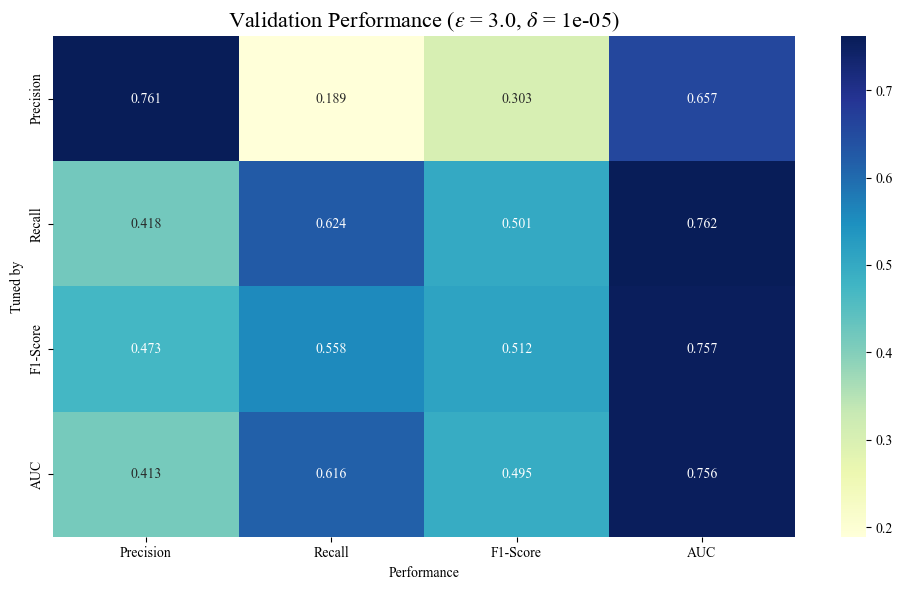

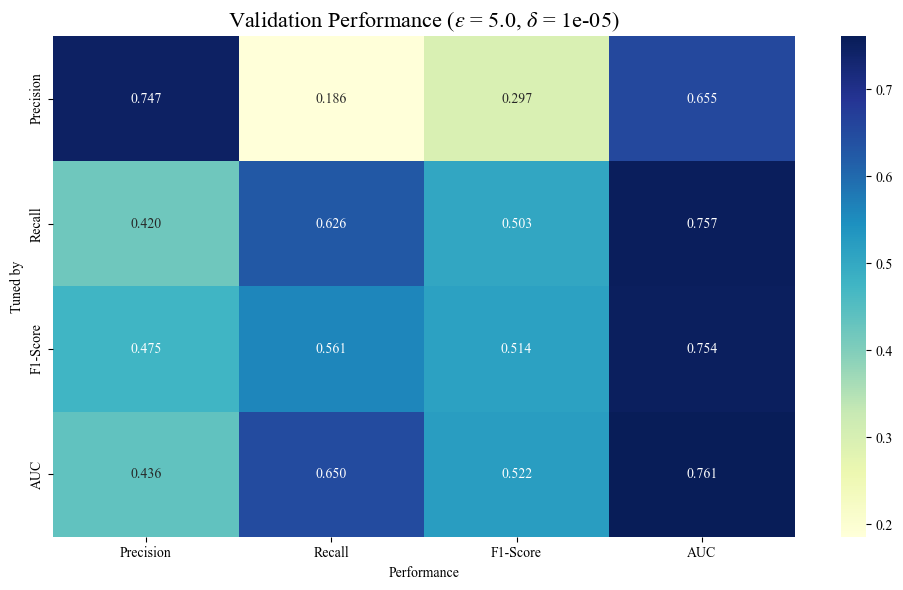

In [11]:
##################################################
## Plot a heatmap of the validation performance ##
##################################################
 
valeval.plot_heatmap(eval_results)